
# Objetivo:
El objetivo de esta parte del trabajo práctico es desarrollar un sistema de detección de rostros usando la red neuronal preentrenada MTCNN.

A partir de un dataset de imágenes con múltiples personas, se identifican automáticamente los rostros presentes en cada imagen y se los recorta para ser utilizados posteriormente en la clasificación de emociones.

Este proceso constituye el preprocesamiento necesario para alimentar el clasificador de emociones que será desarrollado en la siguiente etapa del proyecto.


1. Instalación de librerías

In [1]:
!pip install facenet-pytorch


2. Importación de librerías

In [2]:
# Librerías
import os
import torch
from torchvision import datasets, transforms
from facenet_pytorch import MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import shutil


3. Configuración del entorno.

In [3]:
# Configuración
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device, post_process=True)

  
4. Descarga y descompresión del dataset
5. Definición de rutas

In [4]:
# Descargar el dataset desde Google Drive (WIDER_train.zip)
!pip install -U gdown

import gdown

url = "https://drive.google.com/uc?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M"
output = "WIDER_train.zip"
gdown.download(url, output, quiet=False)

# Descomprimir el dataset
!unzip -q WIDER_train.zip

# Rutas
ruta_dataset = '/content/WIDER_train/images/'
ruta_salida = '/content/caras_recortadas'
csv_salida = '/content/caras_vs_original.csv'

os.makedirs(ruta_salida, exist_ok=True)

Downloading...
From (original): https://drive.google.com/uc?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M
From (redirected): https://drive.google.com/uc?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M&confirm=t&uuid=edf47887-df28-4408-ae07-1edf7ad7d507
To: /content/WIDER_train.zip
100%|██████████| 1.47G/1.47G [00:22<00:00, 66.4MB/s]


 6. Detección de rostros y recorte

In [6]:
# Recorrido limitado, detección y guardado
MAX_IMAGENES = 1000
data = [] # Lista para guardar la información de cada cara detectada
idx = 0

for root, dirs, files in os.walk(ruta_dataset): # Recorre todas las carpetas e imágenes del dataset
    for nombre_archivo in files:
        if idx >= MAX_IMAGENES:
            break  # Salir si llegamos al límite

        if nombre_archivo.lower().endswith(('.jpg', '.jpeg', '.png')): # Filtra solo imágenes
            path_img = os.path.join(root, nombre_archivo)
            try:
                img = Image.open(path_img).convert('RGB') # Abre la imagen en formato RGB
                boxes, _ = mtcnn.detect(img) # Usa MTCNN para detectar todas las caras

                if boxes is not None: # Si se detectaron caras
                    for i, box in enumerate(boxes):   # Recorre cada cara detectada
                        cara = img.crop(box)  # Recorta la imagen en la región de la cara
                        nombre_salida = f"cara_{idx}.jpg" # Asigna un nombre único
                        path_salida = os.path.join(ruta_salida, nombre_salida)
                        cara.save(path_salida)  # Guarda la cara recortada

                        data.append({
                            'archivo_cara': nombre_salida,  # Nombre del archivo de la cara
                            'imagen_original': path_img     # Ruta de la imagen original
                        })
                        idx += 1

                        if idx >= MAX_IMAGENES:
                            break  # Salir del bucle interno también
            except Exception as e:
                print(f"Error con {path_img}: {e}")

# Guardar CSV con los resultados actuales
df = pd.DataFrame(data)
df.to_csv(csv_salida, index=False)

print("Proceso finalizado.")
print(f"Caras recortadas: {len(df)}")
print(f"CSV guardado en: {csv_salida}")


Proceso finalizado.
Caras recortadas: 1000
CSV guardado en: /content/caras_vs_original.csv


7. Creación del Dataset PyTorch

In [7]:
from torch.utils.data import Dataset

class FaceDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]['archivo_cara'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


8. Transformaciones y prueba

Número de caras detectadas: 1000


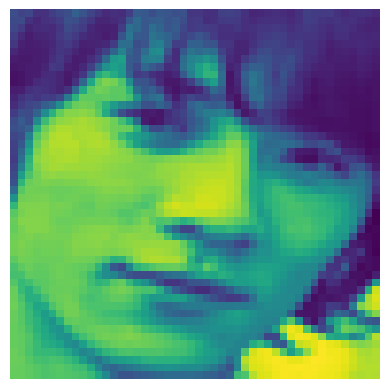

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convierte a escala de grises
    transforms.Resize((48, 48)),                  # Redimensiona a 48x48
    transforms.ToTensor()                         # Convierte a tensor (1, 48, 48)
])


dataset = FaceDataset(csv_path=csv_salida, img_dir=ruta_salida, transform=transform)
print(f"Número de caras detectadas: {len(dataset)}")

# Visualizar una muestra
import matplotlib.pyplot as plt
img = dataset[0]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()


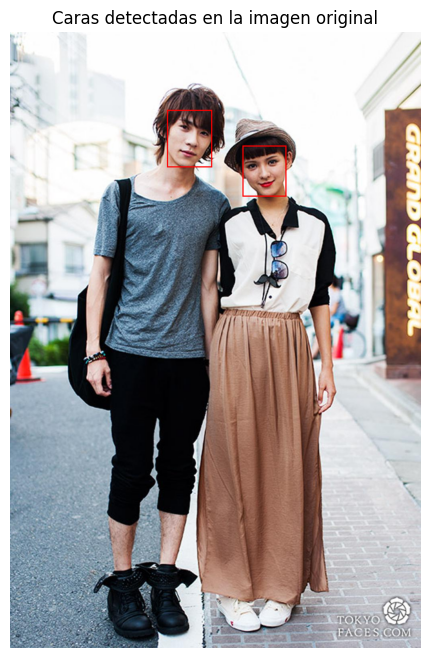

In [10]:
from PIL import ImageDraw

# Elegimos una imagen del dataset original
path_img = dataset.data.iloc[index]['imagen_original']
img = Image.open(path_img).convert('RGB')

# Detectar todas las caras en esa imagen
boxes, _ = mtcnn.detect(img)

# Dibujar las cajas sobre la imagen original
img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)

if boxes is not None:
    for box in boxes:
        draw.rectangle(box.tolist(), outline='red', width=3)

# Mostrar resultado
plt.figure(figsize=(8, 8))
plt.imshow(img_draw)
plt.title("Caras detectadas en la imagen original")
plt.axis('off')
plt.show()


In [12]:
import random

def mostrar_imagen_con_caras(dataset_df, ruta_salida):
    # Elegir una imagen original aleatoria
    imagenes_unicas = dataset_df['imagen_original'].unique()
    imagen_random = random.choice(imagenes_unicas)

    # Filtrar todas las caras correspondientes a esa imagen
    caras = dataset_df[dataset_df['imagen_original'] == imagen_random]

    # Cargar imagen original
    img_original = Image.open(imagen_random)

    # Mostrar imagen original
    plt.figure(figsize=(10, 6))
    plt.subplot(1, len(caras) + 1, 1)
    plt.imshow(img_original)
    plt.title('Original')
    plt.axis('off')

    # Mostrar todas las caras recortadas
    for i, row in enumerate(caras.itertuples(), start=2):
        img_cara = Image.open(os.path.join(ruta_salida, row.archivo_cara))
        plt.subplot(1, len(caras) + 1, i)
        plt.imshow(img_cara)
        plt.title(f"Cara {i-1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


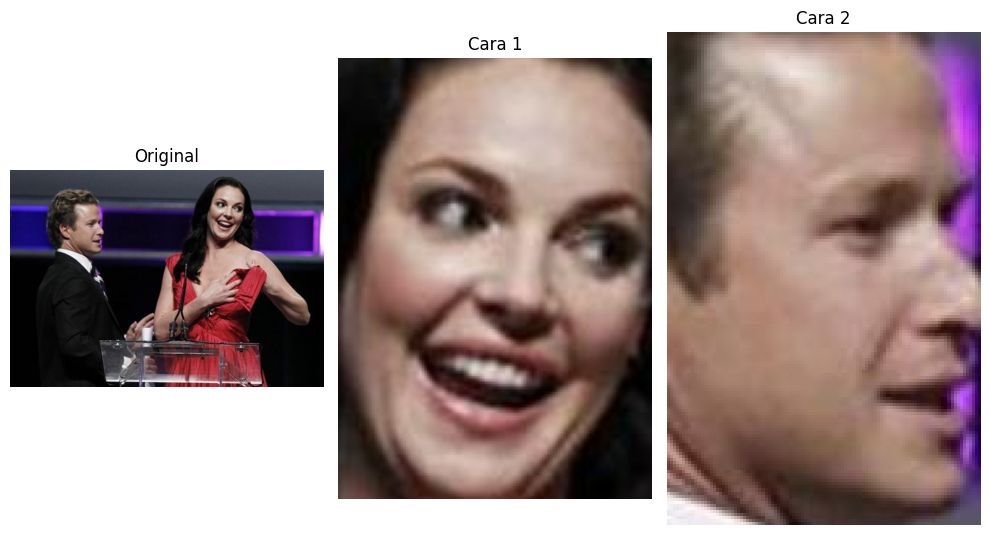

In [19]:
mostrar_imagen_con_caras(df, ruta_salida)


# Conclusion:
Se logró generar un conjunto de datos preprocesado con rostros recortados usando MTCNN. Este dataset será utilizado en la siguiente fase del proyecto para entrenar un modelo de clasificación de emociones faciales mediante fine-tuning sobre FER-2013.
